In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+36.gb29e1911d.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 9.46 GB available memory.


# About this Notebook

We will do stage 1 optimization to get some optimized plasma. This will not consider the coils that are needed but hopefully will be useful for single stage later on.

/CODES/DESC/desc/utils.py:572: UserWarning: Reducing radial (L) resolution can make plasma boundary inconsistent. Recommend calling `eq.surface = eq.get_surface_at(rho=1.0)`
  warnings.warn(msg, err)


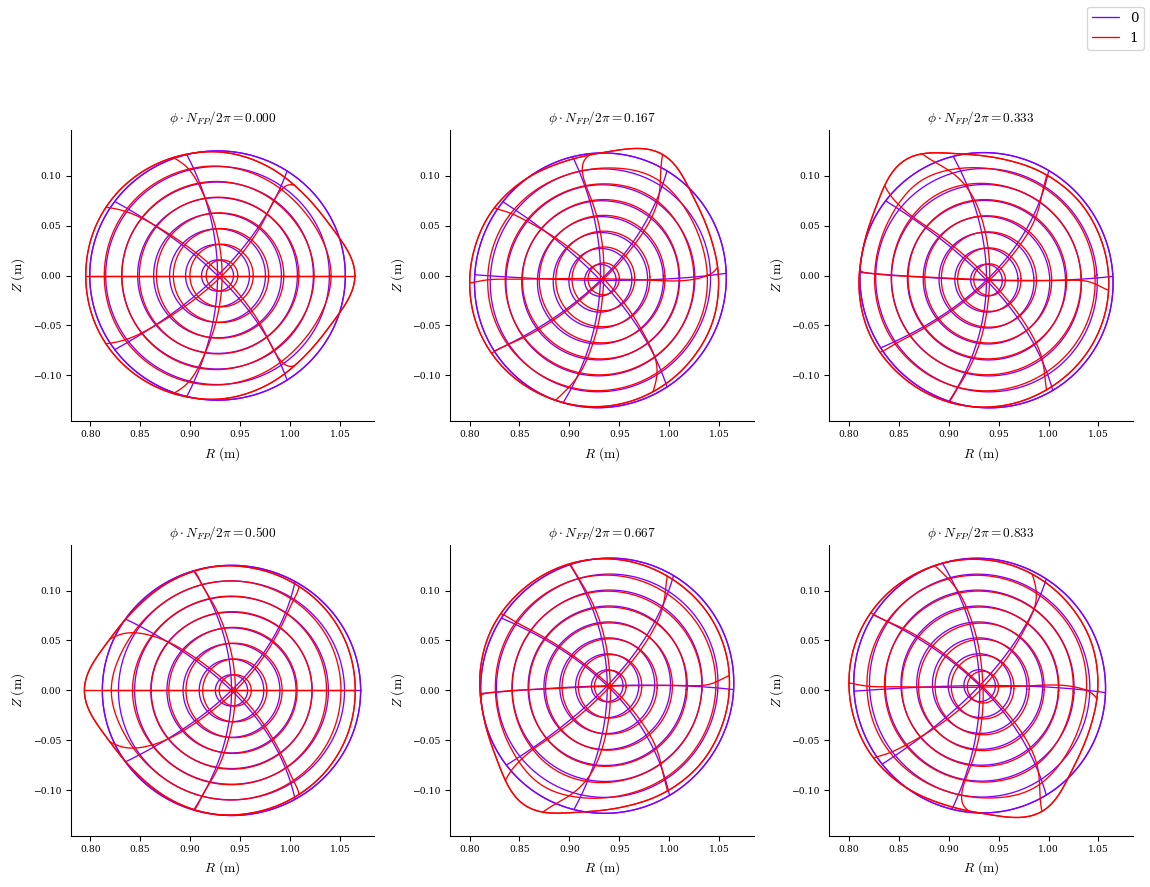

In [6]:
eq0 = load("eq_final2.h5")
eq = eq0.copy()
# remove the sharp edge
eq.change_resolution(L=1, M=1)
eq.change_resolution(L=eq0.L, M=eq0.M)
plot_comparison([eq, eq0]);

In [ ]:
# this is not the same as Rahul's paper but for now should work for testing
curv_grid = Grid(
    nodes=jnp.concatenate(
        [
            jnp.ones(100),
            jnp.linspace(0, 2 * jnp.pi, 100, endpoint=False),
            jnp.linspace(0, 2 * jnp.pi, 100, endpoint=False),
        ]
    ),
    NFP=1,
    sort=False,
    weights=jnp.ones(100),
)
qa_grid = LinearGrid(
    M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
)

## Constraints

In [ ]:
k = 1

modes_R = np.vstack(
    (
        [0, 0, 0],
        eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]

constraints = (
    ForceBalance(eq=eq),
    FixBoundaryR(eq=eq, modes=modes_R),
    FixBoundaryZ(eq=eq, modes=modes_Z),
    FixPsi(eq=eq),
    FixPressure(eq=eq),
)
if eq.current is not None:
    constraints += (FixCurrent(eq=eq),)
else:
    constraints += (FixIota(eq=eq),)

## Objectives



In [ ]:
weights = {
    "curv": 10,
    "qa": 20,
}
objective = ObjectiveFunction(
    (
        # since the shape change is small the omnigenity shouldn't be affected
        # if necessary put QA objective
        GenericObjective(
            "curvature_k2_rho",
            eq,
            grid=curv_grid,
            bounds=(-50, -10),
            weight=weights["curv"],
        ),
        QuasisymmetryTwoTerm(
            eq=eq, helicity=(1, eq.NFP), grid=qa_grid, weight=weights["qa"]
        ),
    ),
    deriv_mode="batched",
)

## Optimize

In [ ]:
optimizer = Optimizer("proximal-lsq-exact")
eq, out = optimizer.optimize(
    eq,
    objective,
    constraints,
    verbose=3,
    copy=True,
    ftol=1e-4,
    maxiter=0,
)